# Diagnosing Respiratory and Chest Diseases from X-rays Using Deep Learning

This notebook gets the dataset ready for training a deep learning model to diagnose respiratory and chest diseases from X-ray images. It includes data loading, preprocessing, and splitting into training and validation sets.


### 1 - Kaggle API Key Configuration

- Register on Kaggle
- Create a new API Token [https://www.kaggle.com/settings]
- Upload the key file here as `kaggle.json`

### 2 - Pobranie zbioru danych

- Download dataset: **[Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data)**

In [1]:
import kagglehub

path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Path to dataset files:", path)

c:\Users\Majkel\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 2.29G/2.29G [03:42<00:00, 11.1MB/s]

Extracting files...


Path to dataset files: C:\Users\Majkel\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2


### Moving the Dataset

After downloading the dataset using KaggleHub, move the ZIP file to your working directory and extract it to access the images for further processing.

In [2]:
import os
import shutil

# Create the destination folder
destination = "datasets"
os.makedirs(destination, exist_ok=True)

# Move the folder from 'path' to the new 'datasets' folder
shutil.move(path, os.path.join(destination, os.path.basename(path)))

'datasets\\2'

### Deleting Duplicated Files

If your dataset contains duplicated files (for example, due to repeated downloads or extraction), it is recommended to remove them to ensure data quality and avoid bias during model training. This step helps maintain a clean and reliable dataset for further processing and analysis.

In [3]:
import shutil
shutil.rmtree("./datasets/2/chest_xray/chest_xray")
shutil.rmtree("./datasets/2/chest_xray/__MACOSX")

### 3 - Dataset Preparation

- Import libraries and configuration

In [4]:
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

- Set paths to dataset folders

In [5]:
base_path = "./datasets/2/chest_xray"
train_dir = os.path.join(base_path, "train")
val_dir   = os.path.join(base_path, "val")
test_dir  = os.path.join(base_path, "test")

- Count images in each class and set

In [6]:
def count_images(directory):
    classes = ['NORMAL', 'PNEUMONIA']
    for cls in classes:
        folder = os.path.join(directory, cls)
        count = len(os.listdir(folder))
        print(f"{directory.split('/')[-1]} - {cls}: {count} images")

In [7]:
print("Number of images in sets:")
count_images(train_dir)
count_images(val_dir)
count_images(test_dir)

Number of images in sets:
chest_xray\train - NORMAL: 1341 images
chest_xray\train - PNEUMONIA: 3875 images
chest_xray\val - NORMAL: 8 images
chest_xray\val - PNEUMONIA: 8 images
chest_xray\test - NORMAL: 234 images
chest_xray\test - PNEUMONIA: 390 images


- Move images from `train` to `val` (to balance the distribution)

In [8]:
def split_dataset_by_proportion(class_folder, train_dir, val_dir, test_dir, train_prop=0.75, val_prop=0.10, test_prop=0.15):
    files = [f for f in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, f))]
    random.shuffle(files)
    total = len(files)
    train_count = int(total * train_prop)
    val_count = int(total * val_prop)
    test_count = total - train_count - val_count

    splits = [
        (files[:train_count], train_dir),
        (files[train_count:train_count+val_count], val_dir),
        (files[train_count+val_count:], test_dir)
    ]

    for split_files, dst_folder in splits:
        os.makedirs(dst_folder, exist_ok=True)
        for file in split_files:
            shutil.move(os.path.join(class_folder, file), os.path.join(dst_folder, file))

# Example usage:
for cls in ['NORMAL', 'PNEUMONIA']:
    # Gather all images from train, val, and test folders for the current class
    all_files = []
    for split_dir in [train_dir, val_dir, test_dir]:
        class_dir = os.path.join(split_dir, cls)
        if os.path.exists(class_dir):
            all_files.extend([os.path.join(class_dir, f) for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])

    # Create a temporary folder to collect all images for splitting
    temp_class_folder = os.path.join(base_path, 'temp_all', cls)
    os.makedirs(temp_class_folder, exist_ok=True)
    for file_path in all_files:
        shutil.move(file_path, os.path.join(temp_class_folder, os.path.basename(file_path)))

    # Split from the temporary folder
    split_dataset_by_proportion(
        temp_class_folder,
        os.path.join(train_dir, cls),
        os.path.join(val_dir, cls),
        os.path.join(test_dir, cls),
        train_prop=0.75, val_prop=0.10, test_prop=0.15
    )

    # Optionally, remove the temporary folder after splitting
    shutil.rmtree(temp_class_folder)

print("After splitting:")
count_images(train_dir)
count_images(val_dir)
count_images(test_dir)

After splitting:
chest_xray\train - NORMAL: 1187 images
chest_xray\train - PNEUMONIA: 3204 images
chest_xray\val - NORMAL: 158 images
chest_xray\val - PNEUMONIA: 427 images
chest_xray\test - NORMAL: 238 images
chest_xray\test - PNEUMONIA: 642 images


- Check image sizes

In [9]:
def get_image_shapes(folder):
    shapes = []
    for root, _, files in os.walk(folder):
        for fname in files:
            img_path = os.path.join(root, fname)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                shapes.append(img.shape)
    return shapes

shapes = get_image_shapes(train_dir)
unique_shapes = set(shapes)
print(f"Unique image sizes in train set: {unique_shapes}")

Unique image sizes in train set: {(1612, 1774), (664, 952), (635, 925), (560, 1160), (1515, 1612), (1048, 1472), (720, 1112), (347, 607), (1672, 1824), (1056, 1592), (704, 1024), (883, 1255), (736, 1056), (656, 984), (849, 1262), (1368, 1678), (947, 1276), (584, 1224), (560, 1016), (2096, 2008), (688, 936), (552, 1240), (672, 928), (1044, 1474), (1959, 2268), (616, 1176), (736, 1092), (624, 1000), (1056, 1448), (576, 960), (621, 1111), (1088, 1400), (647, 1020), (632, 1120), (879, 1406), (712, 1000), (584, 1080), (560, 872), (1048, 1184), (944, 1472), (1592, 1836), (536, 1152), (744, 952), (1237, 1608), (568, 992), (1442, 1748), (648, 1064), (808, 1202), (2155, 2444), (576, 816), (1000, 1552), (2329, 2480), (1145, 1790), (632, 976), (1040, 1216), (1283, 1840), (897, 1396), (1558, 1816), (584, 936), (1677, 1916), (1743, 2090), (1489, 1716), (536, 1008), (616, 888), (289, 493), (1442, 1604), (1608, 1902), (1231, 1686), (1067, 1318), (1152, 1542), (1619, 1682), (472, 880), (584, 792), (98

- Image dimension statistics

In [10]:
def image_size_stats(shapes):
    heights = [h for h, w in shapes]
    widths = [w for h, w in shapes]

    avg_height = np.mean(heights)
    avg_width = np.mean(widths)

    min_height = np.min(heights)
    min_width = np.min(widths)

    max_height = np.max(heights)
    max_width = np.max(widths)

    print(f"Average image size: {avg_height:.1f} x {avg_width:.1f}")
    print(f"Smallest image size: {min_height} x {min_width}")
    print(f"Largest image size: {max_height} x {max_width}")

image_size_stats(shapes)

Average image size: 969.6 x 1326.4
Smallest image size: 127 x 384
Largest image size: 2628 x 2916


- Display one image (NORMAL/PNEUMONIA) from each set


Set: TRAIN


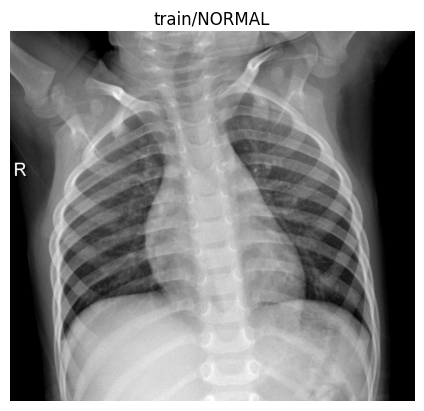

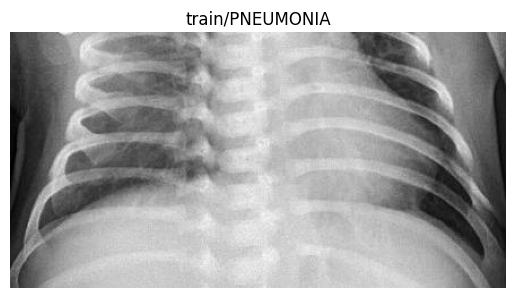


Set: VAL


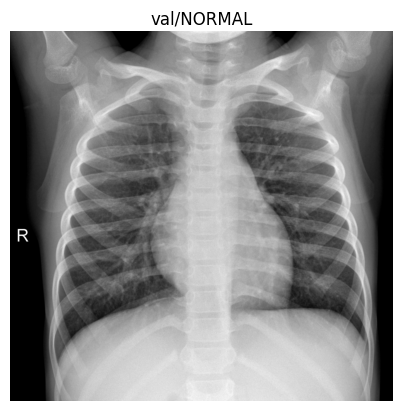

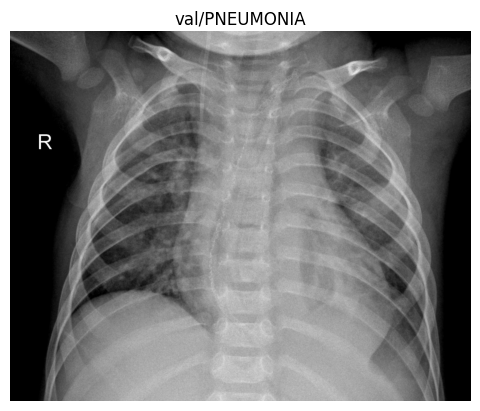


Set: TEST


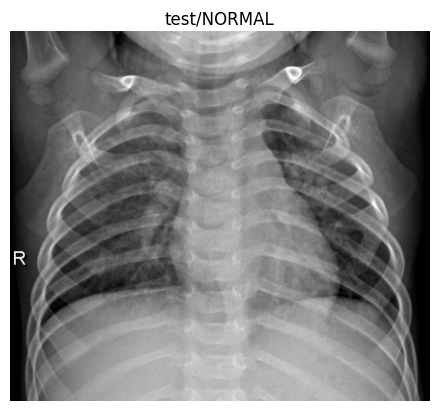

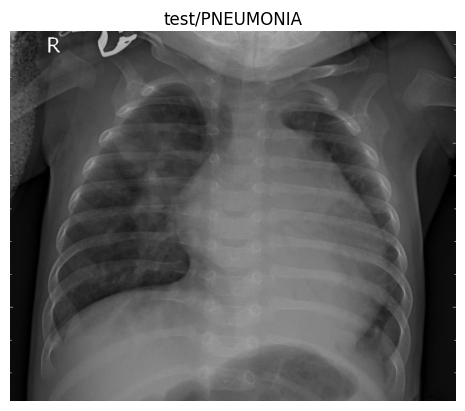

In [11]:
def show_sample_images(base_dir):
    for subset in ["train", "val", "test"]:
        print(f"\nSet: {subset.upper()}")
        for cls in ["NORMAL", "PNEUMONIA"]:
            path = os.path.join(base_dir, subset, cls)
            img_file = random.choice(os.listdir(path))
            img = cv2.imread(os.path.join(path, img_file), cv2.IMREAD_GRAYSCALE)
            plt.imshow(img, cmap='gray')
            plt.title(f"{subset}/{cls}")
            plt.axis("off")
            plt.show()

show_sample_images(base_path)

- Preprocessing and normalization of images

In [12]:
from tqdm import tqdm

IMG_SIZE = (256, 256)  # target size

def preprocess_and_save(src_path, dst_path):
    os.makedirs(dst_path, exist_ok=True)
    for fname in tqdm(os.listdir(src_path), desc=f"Processing {os.path.basename(dst_path)}"):
        fpath = os.path.join(src_path, fname)
        if not fname.lower().endswith((".jpeg", ".jpg", ".png")):
            continue
        try:
            img = tf.io.read_file(fpath)
            img = tf.image.decode_jpeg(img, channels=1)
            img = tf.image.resize(img, IMG_SIZE)
            img = tf.cast(img, tf.uint8)
            tf.keras.preprocessing.image.save_img(os.path.join(dst_path, fname), img)
        except Exception as e:
            print(f"Error processing {fname}: {e}")

# Processing for each subset and class using base_path
for split in ['train', 'val', 'test']:
    for label in ['NORMAL', 'PNEUMONIA']:
        input_dir = os.path.join(base_path, split, label)
        output_dir = os.path.join(base_path, f"{split}_{IMG_SIZE[0]}x{IMG_SIZE[1]}", label)
        preprocess_and_save(input_dir, output_dir)


Processing PNEUMONIA: 100%|██████████| 642/642 [00:08<00:00, 79.36it/s]


- Update paths to the new directory with normalized images

In [13]:
base_path = "./datasets/2/chest_xray"
train_dir = os.path.join(base_path, "train_256x256")
val_dir   = os.path.join(base_path, "val_256x256")
test_dir  = os.path.join(base_path, "test_256x256")

- Data augmentation

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img

# Set up augmentation generator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.85, 1.15],
    zoom_range=0.08
)

def augment_and_save(image_path, save_dir):
    img = load_img(image_path, color_mode="grayscale")
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    augmented = next(datagen.flow(img_array, batch_size=1))[0]
    filename = "aug_" + os.path.basename(image_path)
    save_path = os.path.join(save_dir, filename)
    save_img(save_path, augmented)

def process_folder(folder_path):
    for label in os.listdir(folder_path):
        label_folder = os.path.join(folder_path, label)
        if not os.path.isdir(label_folder):
            continue
        for img_name in os.listdir(label_folder):
            img_path = os.path.join(label_folder, img_name)
            augment_and_save(img_path, label_folder)
        print(f"Finished {label}")

# Augment data in train, test, and val folders
process_folder(train_dir)
process_folder(test_dir)
process_folder(val_dir)

Finished NORMAL
Finished PNEUMONIA
Finished NORMAL
Finished PNEUMONIA
Finished NORMAL
Finished PNEUMONIA


- Verify augmentation process, display image counts

In [16]:
print("Number of images in sets:")
count_images(train_dir)
count_images(val_dir)
count_images(test_dir)

Number of images in sets:
chest_xray\train_256x256 - NORMAL: 2374 images
chest_xray\train_256x256 - PNEUMONIA: 6408 images
chest_xray\val_256x256 - NORMAL: 316 images
chest_xray\val_256x256 - PNEUMONIA: 854 images
chest_xray\test_256x256 - NORMAL: 476 images
chest_xray\test_256x256 - PNEUMONIA: 1284 images


- Display sample images

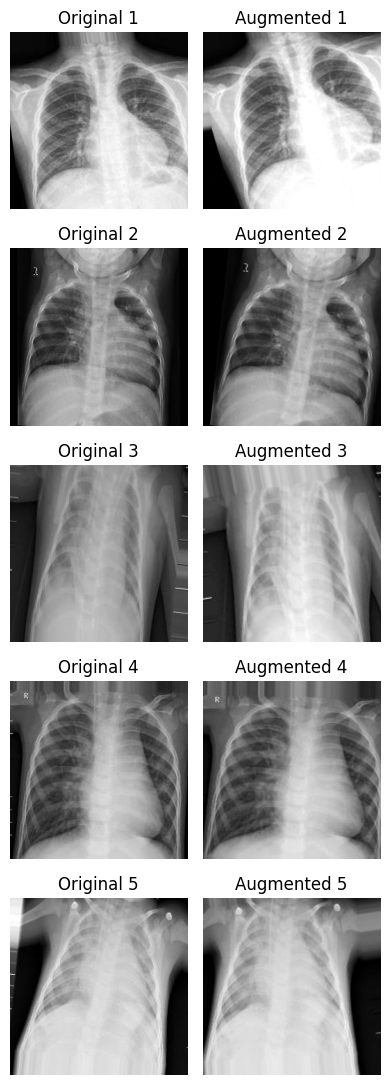

In [17]:
def show_random_images_with_augmentation(folder_path, num_images=5):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpeg', 'jpg', 'png'))]
    random_images = random.sample(image_files, num_images)
    plt.figure(figsize=(4, 11))
    for i, img_name in enumerate(random_images, 1):
        img_path = os.path.join(folder_path, img_name)
        img = load_img(img_path, color_mode="grayscale")
        img_array = img_to_array(img)
        augmented_img = next(datagen.flow(img_array.reshape((1, *img_array.shape))))[0].astype('uint8')
        plt.subplot(num_images, 2, 2*i-1)
        plt.imshow(img_array.squeeze(), cmap='gray')
        plt.title(f"Original {i}")
        plt.axis('off')
        plt.subplot(num_images, 2, 2*i)
        plt.imshow(augmented_img.squeeze(), cmap='gray')
        plt.title(f"Augmented {i}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

normal_folder = os.path.join(base_path, 'train_256x256/PNEUMONIA')
show_random_images_with_augmentation(normal_folder, num_images=5)

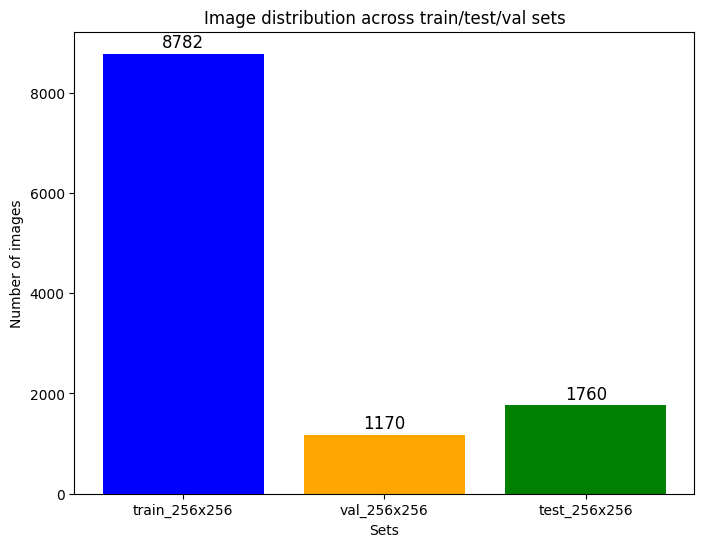

In [18]:
# Function to count images in train, val, test folders
def count_images_in_folders(base_path, folders):
    counts = {}
    for folder in folders:
        folder_path = os.path.join(base_path, folder)
        if os.path.exists(folder_path):
            total_images = 0
            for subfolder in ['NORMAL', 'PNEUMONIA']:
                subfolder_path = os.path.join(folder_path, subfolder)
                if os.path.exists(subfolder_path):
                    image_files = [f for f in os.listdir(subfolder_path) if f.endswith(('jpeg', 'jpg', 'png'))]
                    total_images += len(image_files)
            counts[folder] = total_images
        else:
            counts[folder] = 0
    return counts

folders = ['train_256x256', 'val_256x256', 'test_256x256']
image_counts = count_images_in_folders(base_path, folders)

# Bar plot
def plot_image_distribution(image_counts):
    plt.figure(figsize=(8, 6))
    bars = plt.bar(image_counts.keys(), image_counts.values(), color=['blue', 'orange', 'green'])
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 50, int(yval), ha='center', va='bottom', fontsize=12)
    plt.title("Image distribution across train/test/val sets")
    plt.xlabel("Sets")
    plt.ylabel("Number of images")
    plt.show()

plot_image_distribution(image_counts)